In [1]:
# default_exp main

In [2]:
import os
os.chdir('..')
os.getcwd()

'/home/ubuntu/hw2p2'

In [3]:
#hide
%load_ext autoreload
%autoreload 2

In [4]:
#export
# imports
import os
import time
import pickle
import argparse
from functools import partial
import json
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms
from PIL import Image
from sklearn.metrics import roc_auc_score

from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from hyperopt.pyll.base import scope

In [5]:
#export
SIZE = 64
NO_TRANSF = [transforms.ToTensor(),
             transforms.Resize(SIZE)]

TRAIN_TRANSF = [transforms.Resize(SIZE),
                #transforms.RandomCrop(64),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.225, 0.226, 0.225],
                                     std=[0.5, 0.5, 0.5])]

VAL_TRANSF = [transforms.Resize(SIZE),
              transforms.ToTensor(),
              transforms.Normalize(mean=[0.225, 0.226, 0.225],
                                   std=[0.5, 0.5, 0.5])]

# DATASETS

In [6]:
#export
class FaceClassificationDataset(Dataset):
    """
    """
    def __init__(self,
                 mode,
                 trans_list):

        # Assertions to avoid wrong inputs
        assert mode in ['train', 'val', 'test']
        assert mode == 'test' and n_classes == None or mode != 'test'

        # Directory setup
        data_dirs = {'train': './data/s1/train_data',
                     'val': './data/s1/val_data',
                     'test': './data/s1/test_data'}
        self.data_dir = data_dirs[mode]
        self.mode = mode
        self.trans_list = trans_list

        # Labels
        if (mode in ['train', 'val']):
            #self.labels = np.array([int(d) for d in os.listdir(self.data_dir)])
            self.labels = np.array([int(d) for d in os.listdir(self.data_dir) \
                                           for file in os.listdir(f'{self.data_dir}/{d}') if '.ipynb' not in file])
            
            self.X = np.array([str(file) for d in os.listdir(self.data_dir) \
                                           for file in os.listdir(f'{self.data_dir}/{d}') if '.ipynb' not in file])
            
            #self.labels = self.labels[:50_000]
            #self.X = self.X[:50_000]
        
        elif mode == 'test':
            self.labels = os.listdir(self.data_dir)
            self.labels = np.array([int(f.split('.')[0]) for f in self.labels])
            self.labels.sort(axis=0)

            self.map_files = []
            for l in self.labels:
                temp_ls = [(l, f) for f in \
                    os.listdir(os.path.join(self.data_dir, str(l)))]
                temp_ls = [(t[0], t[1]) for t in temp_ls]
                self.map_files.append(temp_ls)

            self.map_files = [t for sl in self.map_files for t in sl]
            self.labels = [t[0] for t in self.map_files]
            self.X = [t[1] for t in self.map_files]
   
    def __len__(self): 
            return len(self.X)

    def __getitem__(self, idx):
        preprocess = transforms.Compose(self.trans_list)
        
        image_path = os.path.join(self.data_dir, 
                                  str(self.labels[idx]), 
                                  self.X[idx])
        image_tensor = Image.open(image_path)
        image_tensor = preprocess(image_tensor)

        if self.mode == 'test': 
            return image_tensor
        else: 
            return image_tensor, self.labels[idx]

In [7]:
#export
class FaceVerificationDataset(Dataset):
    """
    """
    def __init__(self,
                 mode,
                 trans_list):

        # Assertions to avoid wrong inputs
        assert mode in ['val', 'test']
        assert mode == 'test' and sample == None or mode != 'test'

        # Directory setup
        pairs_dirs = {'val': './data/s2/verification_pairs_val.txt',
                     'test': './data/s2/verification_pairs_test.txt'}
        self.pairs_dir = pairs_dirs[mode]
        self.mode = mode
        self.trans_list = trans_list

        with open(self.pairs_dir) as f:
            self.pairs = [l.rstrip().split() for l in f]
   
    def __len__(self): 
        return len(self.pairs)

    def __getitem__(self, idx):
        preprocess = transforms.Compose(self.trans_list)
        
        image_tensor_0 = Image.open('./data/s2/' + self.pairs[idx][0])
        image_tensor_1 = Image.open('./data/s2/' + self.pairs[idx][1])
        
        image_tensor_0 = preprocess(image_tensor_0)
        image_tensor_1 = preprocess(image_tensor_1)
        
        if self.mode == 'test': 
            return image_tensor_0, image_tensor_1
        else: 
            return image_tensor_0, image_tensor_1, int(self.pairs[idx][2])

## Visualization of original dataset

batch_x.shape torch.Size([4, 3, 64, 64])
batch_y.shape torch.Size([4])


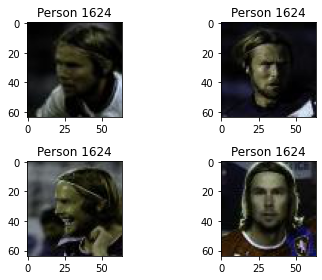

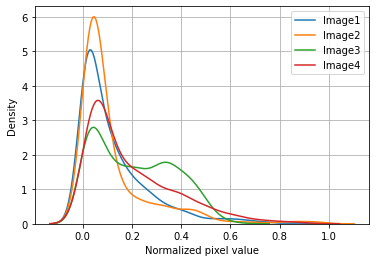

In [8]:
dataset = FaceClassificationDataset(trans_list=NO_TRANSF, mode='train')
dataloader = DataLoader(dataset, shuffle=False, batch_size=4, num_workers=0, drop_last=True)

batch_x, batch_y = next(iter(dataloader))
print("batch_x.shape", batch_x.shape)
print("batch_y.shape", batch_y.shape)

fig, axs = plt.subplots(2,2)
axs[0,0].imshow(batch_x[0,:,:,:].permute(1, 2, 0))
axs[0,0].set_title(f'Person {batch_y[0]}')

axs[0,1].imshow(batch_x[1,:,:,:].permute(1, 2, 0))
axs[0,1].set_title(f'Person {batch_y[1]}')

axs[1,0].imshow(batch_x[2,:,:,:].permute(1, 2, 0))
axs[1,0].set_title(f'Person {batch_y[2]}')

axs[1,1].imshow(batch_x[3,:,:,:].permute(1, 2, 0))
axs[1,1].set_title(f'Person {batch_y[3]}')
fig.tight_layout()
plt.savefig('./results/original_dataset.png')
plt.show()

pixels = batch_x.reshape(len(batch_x), -1)
sample = np.random.choice(range(pixels.shape[1]), 1000)

ax = sns.kdeplot(data=pixels[0, sample], label='Image1')
sns.kdeplot(data=pixels[1, sample], label='Image2')
sns.kdeplot(data=pixels[2, sample], label='Image3')
sns.kdeplot(data=pixels[3, sample], label='Image4')
plt.grid()
plt.legend()
ax.set(xlabel='Normalized pixel value')
plt.savefig('./results/original_distribution.png')

### Visualization of training dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


batch_x.shape torch.Size([4, 3, 64, 64])
batch_y.shape torch.Size([4])


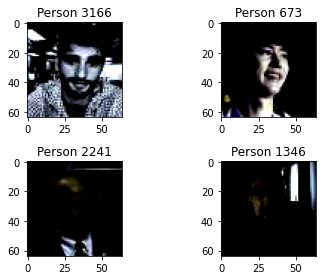

np.mean(pixels[3, sample]) tensor(0.1274)
np.mean(pixels[1, sample]) tensor(-0.2158)
np.mean(pixels[2, sample]) tensor(-0.2936)
np.mean(pixels[3, sample]) tensor(-0.2676)


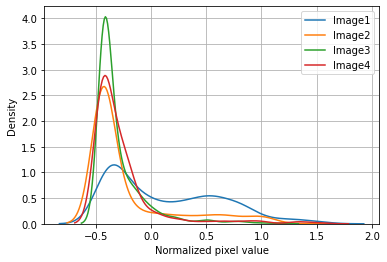

In [9]:
dataset = FaceClassificationDataset(trans_list=TRAIN_TRANSF, mode='val')
dataloader = DataLoader(dataset, shuffle=True, batch_size=4, num_workers=0, drop_last=True)

batch_x, batch_y = next(iter(dataloader))
print("batch_x.shape", batch_x.shape)
print("batch_y.shape", batch_y.shape)

fig, axs = plt.subplots(2,2)
axs[0,0].imshow(batch_x[0,:,:,:].permute(1, 2, 0))
axs[0,0].set_title(f'Person {batch_y[0]}')

axs[0,1].imshow(batch_x[1,:,:,:].permute(1, 2, 0))
axs[0,1].set_title(f'Person {batch_y[1]}')

axs[1,0].imshow(batch_x[2,:,:,:].permute(1, 2, 0))
axs[1,0].set_title(f'Person {batch_y[2]}')

axs[1,1].imshow(batch_x[3,:,:,:].permute(1, 2, 0))
axs[1,1].set_title(f'Person {batch_y[3]}')
fig.tight_layout()
plt.savefig('./results/train_dataset.png')
plt.show()

# Distribution plot
pixels = batch_x.reshape(len(batch_x), -1)
sample = np.random.choice(range(pixels.shape[1]), 1000)

print("np.mean(pixels[3, sample])", pixels[0, sample].mean())
print("np.mean(pixels[1, sample])", pixels[1, sample].mean())
print("np.mean(pixels[2, sample])", pixels[2, sample].mean())
print("np.mean(pixels[3, sample])", pixels[3, sample].mean())

ax = sns.kdeplot(data=pixels[0, sample], label='Image1')
sns.kdeplot(data=pixels[1, sample], label='Image2')
sns.kdeplot(data=pixels[2, sample], label='Image3')
sns.kdeplot(data=pixels[3, sample], label='Image4')
plt.grid()
plt.legend()
ax.set(xlabel='Normalized pixel value')
plt.savefig('./results/train_distribution.png')

## Check verification dataset

batch_x1.shape torch.Size([4, 3, 64, 64])
batch_x2.shape torch.Size([4, 3, 64, 64])
batch_y.shape torch.Size([4])


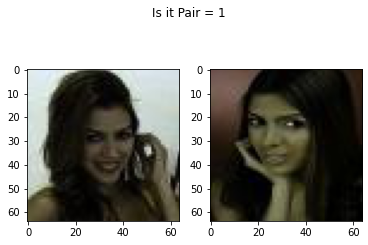

In [10]:
dataset = FaceVerificationDataset(trans_list=NO_TRANSF, mode='val')
dataloader = DataLoader(dataset, shuffle=True, batch_size=4, num_workers=0, drop_last=True)

batch_x1, batch_x2, batch_y = next(iter(dataloader))
print("batch_x1.shape", batch_x1.shape)
print("batch_x2.shape", batch_x2.shape)
print("batch_y.shape", batch_y.shape)

fig, axs = plt.subplots(1,2)
axs[0].imshow(batch_x1[0,:,:,:].permute(1, 2, 0))
axs[1].imshow(batch_x2[0,:,:,:].permute(1, 2, 0))
fig.suptitle(f'Is it Pair = {batch_y[0]}')
plt.show()

# ResNet

In [11]:
# export
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class _ResNet(nn.Module):
    def __init__(self, block, num_blocks, input_size=64, num_classes=10):
        super(_ResNet, self).__init__()
        self.in_planes = input_size

        self.conv1 = nn.Conv2d(3, input_size, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(input_size)
        self.layer1 = self._make_layer(block, input_size, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        
        #self.linear = nn.Linear(512*block.expansion, num_classes)
        self.linear = nn.Linear(512*4, num_classes)
        
        print("512*block.expansion", 512*block.expansion)
        print("num_classes", num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        embeds = F.avg_pool2d(out, 4)
        embeds = embeds.view(embeds.size(0), -1)
        last = self.linear(embeds)
        return last, embeds

In [12]:
# export
class CenterLoss(nn.Module):
    """Center loss.
    
    Reference:
    Wen et al. A Discriminative Feature Learning Approach for Deep Face Recognition. ECCV 2016.
    
    Args:
        num_classes (int): number of classes.
        feat_dim (int): feature dimension.
    """
    def __init__(self, num_classes=10, feat_dim=2, use_gpu=True):
        super(CenterLoss, self).__init__()
        self.num_classes = num_classes
        self.feat_dim = feat_dim
        self.use_gpu = use_gpu

        if self.use_gpu:
            self.centers = nn.Parameter(torch.randn(self.num_classes, self.feat_dim).cuda())
        else:
            self.centers = nn.Parameter(torch.randn(self.num_classes, self.feat_dim))

    def forward(self, x, labels):
        """
        Args:
            x: feature matrix with shape (batch_size, feat_dim).
            labels: ground truth labels with shape (batch_size).
        """
        batch_size = x.size(0)
        distmat = torch.pow(x, 2).sum(dim=1, keepdim=True).expand(batch_size, self.num_classes) + \
                  torch.pow(self.centers, 2).sum(dim=1, keepdim=True).expand(self.num_classes, batch_size).t()
        #distmat.addmm_(1, -2, x, self.centers.t())
        
        distmat = torch.addmm(input=distmat, 
                      mat1=x, 
                      mat2=self.centers.t(), 
                      beta=1, 
                      alpha=-2)

        classes = torch.arange(self.num_classes).long()
        if self.use_gpu: classes = classes.cuda()
        labels = labels.unsqueeze(1).expand(batch_size, self.num_classes)
        mask = labels.eq(classes.expand(batch_size, self.num_classes))

        dist = distmat * mask.float()
        loss = dist.clamp(min=1e-12, max=1e+12).sum() / batch_size

        return loss

In [13]:
# export
class ResNet(object):
    def __init__(self, params):
        
        super().__init__()
        self.params = params
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        # Instantiate model
        torch.manual_seed(params['random_seed'])
        np.random.seed(params['random_seed'])
        self.model = _ResNet(block=BasicBlock, 
                             num_blocks=[2, 2, 2, 2],
                             num_classes=params['n_classes'],
                             input_size=params['input_size']).to(self.device)
        
        #self.centroids = _CenterLoss(num_classes=params['n_classes'], 
        #                             feat_dim=512*4).to(self.device)
        self.center_loss = CenterLoss(num_classes=params['n_classes'], feat_dim=512*4, use_gpu=True)

    def adjust_lr(self, optimizer, lr_decay):
        for param_group in optimizer.param_groups:
            param_group['lr'] = param_group['lr'] * lr_decay

    def save_weights(self, path):
        torch.save(self.model.state_dict(), path)    

    def load_weights(self, path):
        self.model.load_state_dict(torch.load(path,
                                          map_location=torch.device(self.device)))
        self.model.eval()

    def fit(self, train_loader, val_loader, vrf_loader):
        criterion = nn.CrossEntropyLoss()
        params = list(self.model.parameters()) + list(self.center_loss.parameters())
        optimizer = optim.SGD(params, lr=self.params['initial_lr'],
                              momentum=0.9, weight_decay=self.params['weight_decay'])
        #coptimizer = optim.SGD(self.centroids.parameters(), lr=self.params['initial_clr'], momentum=0.9)

        # Initialize counters and trajectories
        step = 0
        epoch = 0
        self.best_acc = -1
        metric_trajectories = {'step':  [],
                               'epoch':  [],
                               'train_loss': [],
                               'train_acc': [],
                               'val_loss': [],
                               'val_acc': []}

        print('\n'+'='*37+' Fitting  ResNet '+'='*37)
        while step <= self.params['iterations']:
            # Train
            epoch += 1
            self.model.train()
            for batch_idx, (inputs, targets) in enumerate(train_loader):
                step+=1
                if step > self.params['iterations']:
                    continue
                inputs, targets = inputs.to(self.device), targets.to(self.device)
                optimizer.zero_grad()
                
                outputs, embeds = self.model(inputs)
                
                loss = criterion(outputs, targets)
                if self.params['with_center_loss']:
                     loss += self.params['alpha'] * self.center_loss(embeds, targets)

                
                loss.backward()
                
                if self.params['with_center_loss']:
                    for param in self.center_loss.parameters():
                        # lr_cent is learning rate for center loss, e.g. lr_cent = 0.5
                        param.grad.data *= (self.params['initial_clr'] / (self.params['alpha'] * self.params['initial_lr']))
                
                optimizer.step()

                # Evaluate metrics
                if (step % self.params['display_step']) == 0:
                    train_loss, train_acc = self.evaluate_performance(loader=train_loader, criterion=criterion)
                    #train_loss, train_acc = 0, 0
                    val_loss, val_acc = self.evaluate_performance(loader=val_loader, criterion=criterion)
                    roc, _ = self.evaluate_roc(loader=vrf_loader)
                    
                    display_str = f'step: {step}\t train_loss: {train_loss:.4f} train_acc {train_acc:.2f}'
                    display_str += f'\t val_loss: {val_loss:.4f} val_acc: {val_acc:.2f} roc {roc:.2f}'
                    print(display_str)
                    
                    if val_acc > self.best_acc:
                        print('Saving..')
                        state = {
                            'net': self.model.state_dict(),
                            'acc': val_acc,
                            'epoch': epoch,
                        }
                        if not os.path.isdir('checkpoint'):
                            os.mkdir('checkpoint')
                        torch.save(state, f"./checkpoint/{self.params['experiment_id']}_ckpt.pth")
                        self.best_acc = val_acc
                
                # Update optimizer learning rate
                if step % self.params['adjust_lr_step'] == 0 and step > 0:
                    self.adjust_lr(optimizer=optimizer, lr_decay=self.params['lr_decay'])

        # Check finish condition
        # TODO: check if epoch is interruptable within
        # if step==self.iterations: break
        print('\n'+'='*35+' Finished Train '+'='*35)
        self.train_loss   = metric_trajectories['train_loss'][-1]
        self.train_acc    = metric_trajectories['train_acc'][-1]
        self.val_loss     = metric_trajectories['val_loss'][-1]
        self.val_acc      = metric_trajectories['val_acc'][-1]
        self.trajectories = metric_trajectories
        
    def evaluate_performance(self, loader, criterion):
        self.model.eval()
        test_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for batch_idx, (inputs, targets) in enumerate(loader):
                inputs, targets = inputs.to(self.device), targets.to(self.device)
                outputs, _ = self.model(inputs)
                loss = criterion(outputs, targets)

                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

        # Save checkpointorch.
        acc = 100.*correct/total
        test_loss = test_loss/total
            
        self.model.train()
        return test_loss, acc
    
    def evaluate_roc(self, loader):
        self.model.eval()
                
        embeds0 = []
        embeds1 = []
        targets = []

        with torch.no_grad():
            for batch_idx, (img0, img1, target) in enumerate(loader):
                img0 = img0.to(self.device)
                img1 = img1.to(self.device)
                
                embeds0 += [self.model(img0)[1].cpu().numpy()]
                embeds1 += [self.model(img1)[1].cpu().numpy()]
                targets += [np.expand_dims(target.cpu().numpy(), 1)]
                
        embeds0  = np.vstack(embeds0)
        embeds1  = np.vstack(embeds1)
        targets  = np.vstack(targets)

        sim_score = np.sum((embeds0 - embeds1) ** 2, axis=1, keepdims=True)        
        roc = roc_auc_score(y_true=targets, y_score=sim_score)
        
        self.model.train()
        return roc, sim_score

# Main

In [14]:
#export
def create_dataloaders(mc):
    num_workers = 8 if torch.cuda.is_available() else 0
    train_dataset = FaceClassificationDataset(trans_list=TRAIN_TRANSF, mode='train')
    clf_dataset   = FaceClassificationDataset(trans_list=VAL_TRANSF, mode='val')
    vrf_dataset   = FaceVerificationDataset(trans_list=VAL_TRANSF, mode='val')

    print(f'n_train: {len(train_dataset)}, n_clf: {len(clf_dataset)}, n_vrf: {len(vrf_dataset)}')

    train_loader = DataLoader(train_dataset, 
                              shuffle=True, 
                              batch_size=mc['batch_size'], 
                              num_workers=num_workers, 
                              pin_memory=torch.cuda.is_available(),
                              drop_last=True)
    
    clf_loader = DataLoader(clf_dataset,
                            shuffle=False, 
                            batch_size=2048,
                            num_workers=num_workers, 
                            pin_memory=torch.cuda.is_available(),
                            drop_last=True)
    
    vrf_loader = DataLoader(vrf_dataset, 
                            shuffle=False, 
                            batch_size=2048,
                            num_workers=num_workers, 
                            pin_memory=torch.cuda.is_available(),
                            drop_last=True)
    
    assert len(train_loader) > 0
    assert len(clf_loader) > 0
    assert len(vrf_loader) > 0
    
    return train_loader, clf_loader, vrf_loader

# RESNET

# HYPERPARAMETER OPTIMIZATION

In [15]:
#export
def fit_predict(mc, verbose, trials=None):
        
    train_loader, clf_loader, vrf_loader = create_dataloaders(mc)

    print(f'\nCurrent directory: {os.getcwd()}\n')
    now = datetime.now().strftime("%d-%m-%y_%H-%M-%S")
    print(now)

    start_time = time.time()
    print('='*26)
    print(pd.Series(mc))
    print('='*26+'\n')
        
    model = ResNet(params=mc)
    model.fit(train_loader=train_loader, 
              val_loader=clf_loader,
              vrf_loader=vrf_loader)
    
    results = {'loss':  1.-model.best_acc,
               'train_loss': model.train_loss,
               'train_acc': model.train_accuracy,
               'val_loss': model.val_loss,
               'val_acc': model.val_c_acc,
               'mc': mc,
               'run_time': time.time()-start_time,
               'trajectories': model.trajectories,
               'time_stamp': now,
               'status': STATUS_OK}
    return results

In [24]:
#export
def main(args, max_evals):
    # Hyperparameters space
    space = {#------------------------------------- Architecture -------------------------------------#
             'experiment_id': hp.choice(label='experiment_id', options=[args.experiment_id]),
             'input_size': hp.choice(label='input_size', options=[SIZE]),
             'n_classes': hp.choice(label='n_classes', options=[4_000]),
             #------------------------------ Optimization Regularization -----------------------------#
             'iterations': hp.choice(label='iterations', options=[300_000]), #(n_samples/batch_size) * epochs = (400_000/128) * 100
             #'iterations': hp.choice(label='iterations', options=[5_000]),
             'display_step': scope.int(hp.choice(label='display_step', options=[1_000])),
             'batch_size': scope.int(hp.choice(label='batch_size', options=[128])),
             #'initial_lr': hp.loguniform(label='lr', low=np.log(5e-3), high=np.log(0.1)),
             'initial_lr': hp.choice(label='initial_lr', options=[0.1]),
             'lr_decay': hp.choice(label='lr_decay', options=[0.5]),
             'adjust_lr_step': hp.choice(label='adjust_lr_step', options=[300_000//3]),
             'weight_decay': hp.choice(label='weight_decay', options=[5e-4]),
             'with_center_loss': hp.choice(label='with_center_loss', options=[True]),
             'initial_clr': hp.choice(label='initial_clr', options=[0.01, 0.05, 0.1, 0.5]),
             'alpha': hp.choice(label='alpha', options=[0.1, 0.01]),
             #'display_step': scope.int(hp.choice(label='eval_epochs', options=[3_000])),
             #------------------------------------- Architecture -------------------------------------#
             'random_seed': scope.int(hp.quniform('random_seed', 1, 10, 1))}

    # Hyperparameters search
    trials = Trials()
    fmin_objective = partial(fit_predict, trials=trials, verbose=True)
    best_model = fmin(fmin_objective, space=space, algo=tpe.suggest, max_evals=max_evals, trials=trials)
    
    # Save output
    hyperopt_file = './results/trials.p'
    with open(hyperopt_file, "wb") as f:
        pickle.dump(trials, f)

In [25]:
# export
def parse_args():
    desc = "Classification/anomaly detection shared trend metric experiment"
    parser = argparse.ArgumentParser(description=desc)
    parser.add_argument('--experiment_id', required=True, type=str, help='string to identify experiment')
    return parser.parse_args()

In [26]:
os.getcwd()
# os.chdir('..')

'/home/ubuntu/hw2p2'

In [ ]:
#export
if __name__ == "__main__":
    #args = parse_args()
    args = pd.Series({'experiment_id': 'exp1'})
    main(args, max_evals=2)

n_train: 380638, n_clf: 8000, n_vrf: 8805            
                                                     
Current directory: /home/ubuntu/hw2p2

20-03-21_07-14-30                                    
adjust_lr_step      100000                           
alpha                  0.1
batch_size             128
display_step          1000
experiment_id         exp1
initial_clr            0.1
initial_lr             0.1
input_size              64
iterations          300000
lr_decay               0.5
n_classes             4000
random_seed             10
weight_decay        0.0005
with_center_loss      True
dtype: object

512*block.expansion                                  
512                                                  
num_classes                                          
4000                                                 
                                                     
===================================== Fitting  ResNet =====================================
  0%|          | 

1